# PRIM - main outcomes

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import numpy as np
from ema_workbench import RealParameter, CategoricalParameter, ScalarOutcome, ema_logging, load_results
from ema_workbench.analysis import lines, prim
from ema_workbench.analysis.plotting_util import Density

In [33]:
wd = r'./results'

### Load results

In [34]:
results = load_results(wd+"/results.tar.gz")
experiments, outcomes = results[0].copy(), results[1].copy()

### Set conditions
Setting thresholds for expected and unexpected output spaces:
- Expected: bike distance exceeds car distance at final time
- Unexpected: car distance does not exceed car distance at final time

In [35]:
def expected(outcomes):
    
    bike_final = np.array([bike_ts[-1] for bike_ts in outcomes["Bike Distance Share"]])
    car_final = np.array([car_ts[-1] for car_ts in outcomes["Car Distance Share"]])

    
    y = (bike_final > car_final)
    
    return y

def unexpected(outcomes):

    bike_final = np.array([bike_ts[-1] for bike_ts in outcomes["Bike Distance Share"]])
    car_final = np.array([car_ts[-1] for car_ts in outcomes["Car Distance Share"]])

    y = (bike_final < car_final) 
    
    return y   

### Plot lines
Grouped by expected and unexpected

condition_met
Unexpected    0.668
Expected      0.332
Name: count, dtype: float64


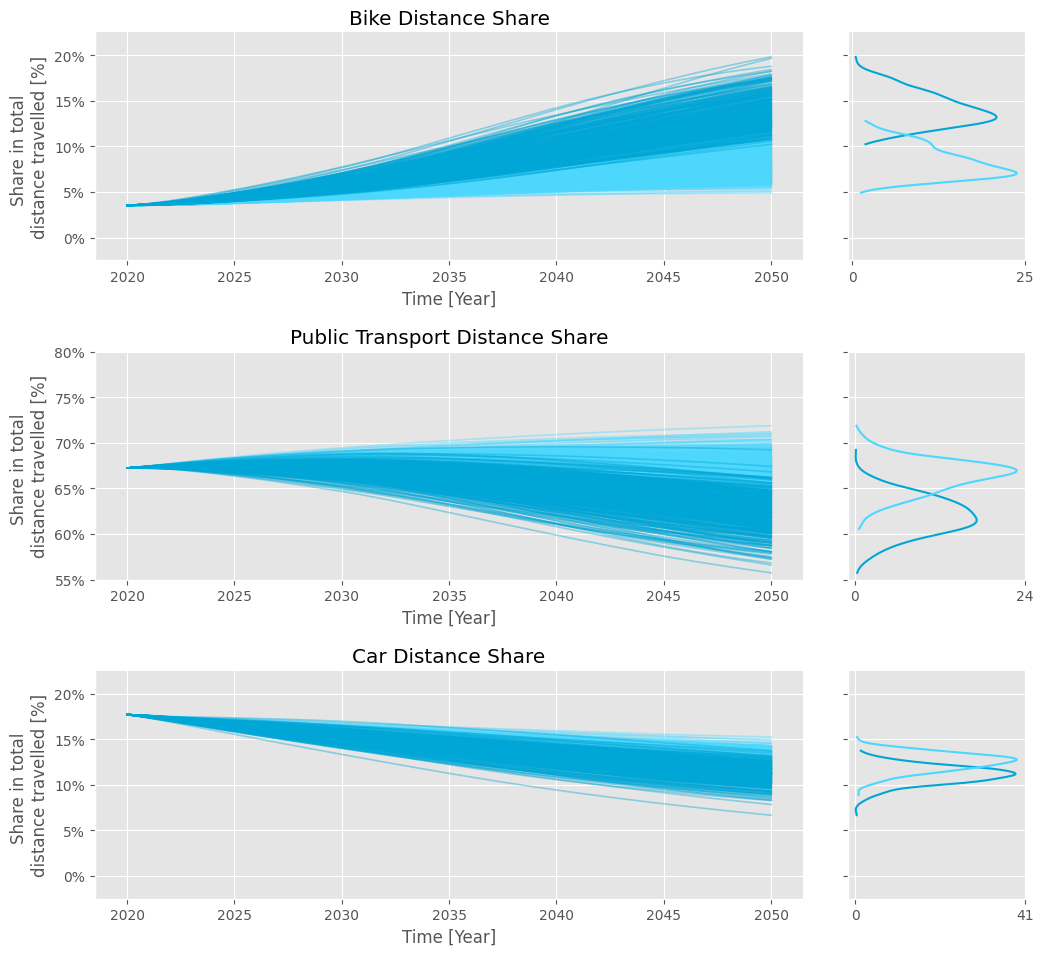

In [41]:
# Basic settings
OUTCOMES = ["Bike Distance Share", "Public Transport Distance Share", "Car Distance Share"]
ylabels = {key: "Share in total \ndistance travelled [%]" for key in OUTCOMES}
plt.rcParams['figure.figsize'] = (12, 3.75 * len(OUTCOMES))
plt.style.use('ggplot')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.it'] = 'Arial:italic'
plt.rcParams['mathtext.rm'] = 'Arial'
colors = ['#4DD7FF', '#00A6D6'] # Condition not met, condition met
HALF = True # only show right half of timeseries

# Mark these outcomes
condition_unmet = unexpected(outcomes)
condition_met = expected(outcomes)
experiments['condition_met'] = np.where(unexpected(outcomes), 'Unexpected', 'Expected')
print(experiments['condition_met'].value_counts() / len(experiments))

# Use standard plotting method grouped by condition
fig, axes = lines(
    experiments,
    outcomes,
    OUTCOMES,
    group_by='condition_met',
    density=Density.KDE,
    ylabels=ylabels,
    legend=False
)

# Set custom y-scales to make sure y-intervals in the graphs are equal, even when limits are different
axes['Car Distance Share'].set_ylim(-0.025, 0.225)
axes['Bike Distance Share'].set_ylim(-0.025, 0.225)
axes['Public Transport Distance Share'].set_ylim(0.55, 0.8)

for label in OUTCOMES:
    axes[label].yaxis.set_major_formatter(PercentFormatter(1,0))

# Now remove the differently colored lines but keep the rest of the axes
lineplot = True
for outcome, ax in axes.items():
    if lineplot:
        for line in ax.lines:
            line.set_visible(False)  # Set transparency for the condition not met lines
        ax.xaxis.set_label_text('Time [Year]')
        lineplot = False
    else:
        ax.lines[0].set_color(colors[1])
        ax.lines[1].set_color(colors[0])
        lineplot = True

# Now redraw the lines, but this time colored based on the condition
for outcome in OUTCOMES:
    ax = axes[outcome]  # Get the correct axis for each outcome

    # Plot lines that meet the condition in blue, with higher z-order to overlay them
    for i, line_data in enumerate(outcomes[outcome]):
        if condition_unmet[i]:  # If condition met, plot in pink on top
            ax.plot(outcomes['TIME'][i], line_data, color=colors[0], linewidth=1.2, zorder=2, alpha=0.4)

    # Plot lines that meet the condition in blue, with higher z-order to overlay them
    for i, line_data in enumerate(outcomes[outcome]):
        if condition_met[i]:  # If condition met, plot in blue on top
            ax.plot(outcomes['TIME'][i], line_data, color=colors[1], linewidth=1.2, zorder=3, alpha=0.4)

# Loop over each axis to despine
for outcome, ax in axes.items():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    
plt.show()
plt.rcdefaults()

In [42]:
fname = "stylized_main_outcomes"
fig.savefig(f"./results/{fname}.png", bbox_inches='tight')

In [21]:
for ref_mode in ["Car Distance Share", "Public Transport Distance Share", "Bike Distance Share"]:
    initial = np.array([ts[0] for ts in outcomes[ref_mode]])
    final = np.array([ts[-1] for ts in outcomes[ref_mode]])
    diff = abs(np.subtract(final, initial))
    max_diff = diff.max() / initial[0]
    min_diff = diff.min() / initial[0]
    print(f'{ref_mode}:\n{min_diff:.0%} - {max_diff:.0%}')

Car Distance Share:
16% - 59%
Public Transport Distance Share:
0% - 16%
Bike Distance Share:
39% - 437%


### Apply PRIM

Run PRIM to determine input parameters with influence

In [14]:
classifiers = {'Expected': expected,
               'Unexpected': unexpected,}

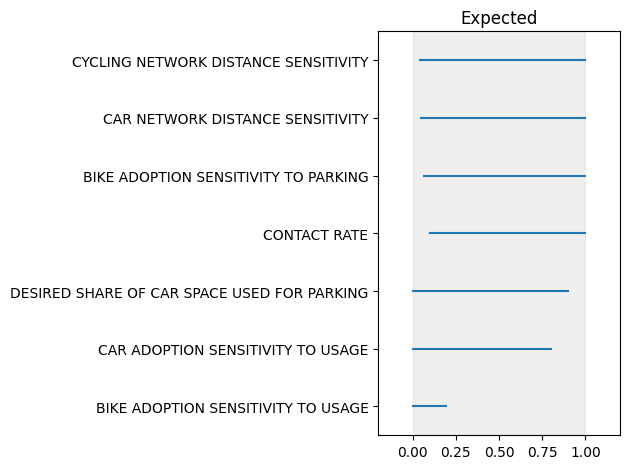

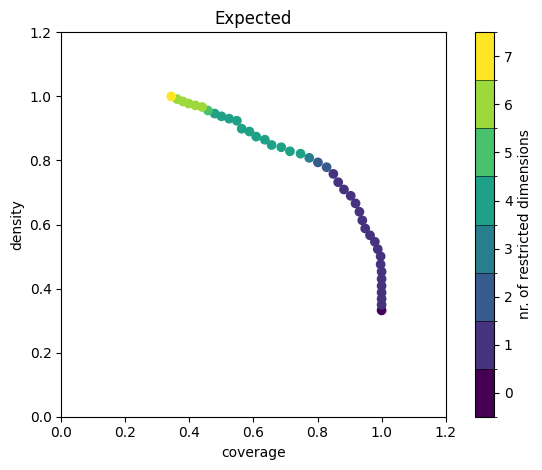

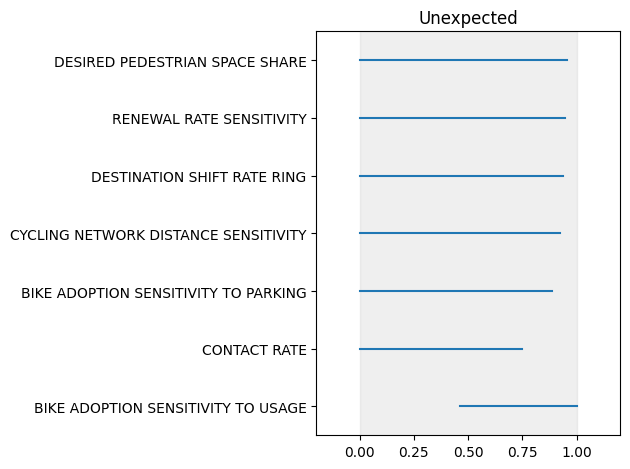

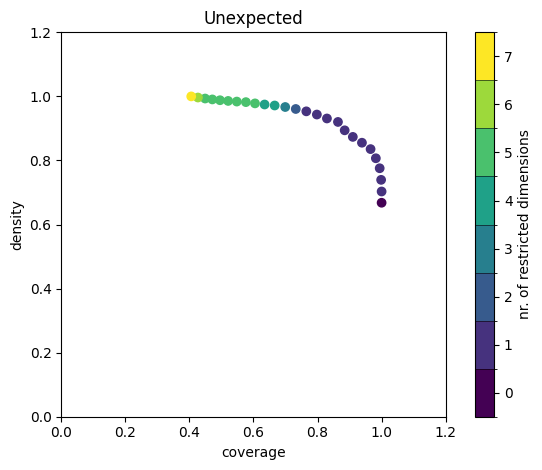

In [31]:
THRESHOLD = 0.5
axes = []

for title, classifier in classifiers.items():
    prim_alg = prim.setup_prim(results, classify=classifier, threshold=THRESHOLD)
    box = prim_alg.find_box()
    prim_alg.show_boxes(True)
    plt.gca().set_title(title)
    plt.tight_layout()
    plt.gcf().savefig(f"./results/{title.lower()}_box.png")
    box.show_tradeoff()
    plt.gca().set_title(title)
    plt.tight_layout()
    plt.gcf().savefig(f"./results/{title.lower()}_tradeoff.png")

In [16]:
traj = box.peeling_trajectory
# i_select = traj.loc[traj['res_dim'] == 7].tail(1).index[0]
# box.select(i_select)
# prim_alg.show_boxes(True)
traj

,coverage,density,id,k,mass,mean,n,res_dim
0,1.000000,0.661000,0,661,1.000,0.661000,1000,0
1,0.998487,0.694737,1,660,0.950,0.694737,950,1
2,0.989410,0.725055,2,654,0.902,0.725055,902,1
3,0.983359,0.759346,3,650,0.856,0.759346,856,1
4,0.972769,0.790898,4,643,0.813,0.790898,813,1
5,0.956127,0.818653,5,632,0.772,0.818653,772,1
6,0.940998,0.848568,6,622,0.733,0.848568,733,1
7,0.918306,0.872126,7,607,0.696,0.872126,696,1
8,0.895613,0.895613,8,592,0.661,0.895613,661,1
9,0.860817,0.907496,9,569,0.627,0.907496,627,1


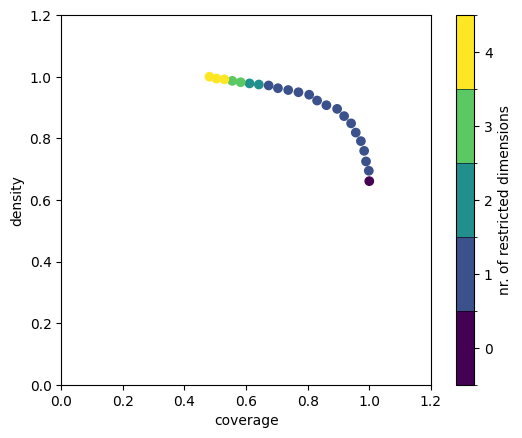

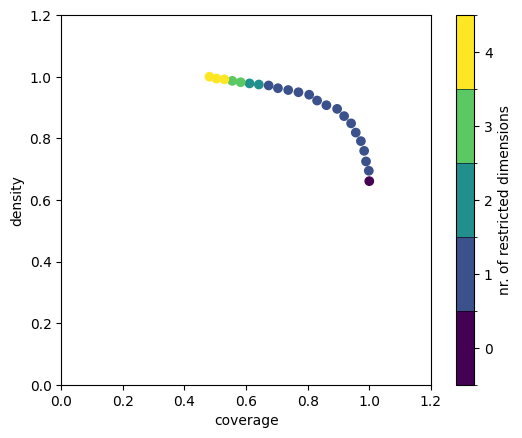

In [17]:
fig, axes = box.show_tradeoff()